# Supervised Learning



# 1. data sets
The data sets are:
1. BankMarketingData
2. PhishingWebsitesData
3. adults income

In [8]:
#importing libraries

import numpy as np
import pandas as pd
import os
from IPython.display import display # to display dataframe

dataPath = "../data/"

In [9]:

# loading Bank Marketing Data
def BankMarketingData(debug=False):
    print(" Loading Bank Marketing Data... \n")
    df_bank = pd.read_csv(dataPath+"BankMarketingData.csv")

    if debug: print(f'{"number of samples":<22} | {"number of features":<22} | {"Any missing data":<22} \n{len(df_bank):<22} | {len(df_bank.columns):<22} | {Ture if df_bank.isnull().values.any() else False:<22}') 

    if debug: 
        print(" \n\nsample bank data:")
        display(df_bank.head())


    if debug: print(" Preprocessing the data ...")

    #It should be noted that the feature 'pdays' is numeric but contains values that are '999' if the customer was not called before. It may be worth while to create a new feature that defines whether or not {0,1} a customer had been called before. In the current state the '999' values may be outliers. 
    #Finally we will standardize all numeric columns.    
    
    # 1- Some features have many categories, as listed below. Convert these features to one-hot encoding. 
    ToOneHot = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    df_bank= pd.get_dummies(df_bank.astype(str), columns=ToOneHot)
    
    if debug: 
        print("after dummies")
        display(df_bank.head())
    
    # 2- reordering
    column_order = list(df_bank)
    column_order.insert(0, column_order.pop(column_order.index('y')))
    df_bank = df_bank.loc[:, column_order]    

    if debug: 
        print("after ordering")
        display(df_bank.head())    
    
    # 3- Convert the target variable from {no,yes} to {0,1} 
    df_bank['y'].replace("no","0",inplace=True)
    df_bank['y'].replace("yes","1",inplace=True) 
   
    df_bank['y'] = df_bank['y'].astype('category')    
    
    if debug: 
        print("after replace ")
        display(df_bank.head())    
    
    # 4- Normalize numerical values
    numCols = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']


    df_num = df_bank[numCols].astype(float)
    df_bank = df_bank.drop(numCols,axis=1)
    df_bank=df_bank.join( (df_num-df_num.min())/(df_num.max()-df_num.min()) )
    df_bank.describe(include='all')    

    if debug: 
        print(" final banking data: ")
        display(df_bank.head())    
    
    return df_bank

BankMarketingData(debug=True)

 Loading Bank Marketing Data... 

number of samples      | number of features     | Any missing data       
45307                  | 21                     | 0                     
 

sample bank data:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


 Preprocessing the data ...
after dummies


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0


after ordering


,y,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,no,56,261,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,1,0
1,no,57,149,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,1,0
2,no,37,226,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,1,0
3,no,40,151,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,1,0
4,no,56,307,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,1,0


after replace 


,y,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,56,261,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,1,0
1,0,57,149,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,1,0
2,0,37,226,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,1,0
3,0,40,151,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,1,0
4,0,56,307,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,0,0,0,0,1,0


 final banking data: 


,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0,0,0,0,1,0,0,0,0,0,...,0.481481,0.053070,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
1,0,0,0,0,0,0,0,0,1,0,...,0.493827,0.030297,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
2,0,0,0,0,0,0,0,0,1,0,...,0.246914,0.045954,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
3,0,1,0,0,0,0,0,0,0,0,...,0.283951,0.030704,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735
4,0,0,0,0,0,0,0,0,1,0,...,0.481481,0.062424,0.0,1.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735


,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0,0,0,0,1,0,0,0,0,0,...,0.481481,0.053070,0.000000,1.0,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735
1,0,0,0,0,0,0,0,0,1,0,...,0.493827,0.030297,0.000000,1.0,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735
2,0,0,0,0,0,0,0,0,1,0,...,0.246914,0.045954,0.000000,1.0,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735
3,0,1,0,0,0,0,0,0,0,0,...,0.283951,0.030704,0.000000,1.0,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735
4,0,0,0,0,0,0,0,0,1,0,...,0.481481,0.062424,0.000000,1.0,0.000000,0.937500,0.698753,0.602510,0.957379,0.859735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45302,0,1,0,0,0,0,0,0,0,0,...,0.160494,0.010777,0.000000,1.0,0.000000,1.000000,0.669135,0.338912,0.980277,1.000000
45303,0,1,0,0,0,0,0,0,0,0,...,0.271605,0.044530,0.000000,1.0,0.000000,1.000000,0.669135,0.338912,0.980503,1.000000
45304,0,0,0,0,0,0,0,0,0,1,...,0.123457,0.013013,0.018182,1.0,0.142857,0.333333,0.269680,0.192469,0.163228,0.512287
45305,0,1,0,0,0,0,0,0,0,0,...,0.506173,0.107361,0.000000,1.0,0.000000,1.000000,0.484412,0.615063,0.982090,1.000000


In [11]:

# loading and processing Phishing Websites Data
def PhishingWebsitesData(debug=False):
    print(" Loading Phishing Websites Data")
    df_phish = pd.read_csv(dataPath+"PhishingWebsitesData.csv")

    if debug:  print(f'{"number of samples":<22} | {"number of features":<22} | {"Any missing data":<22} \n{len(df_phish):<22} | {len(df_phish.columns):<22} | {Ture if df_phish.isnull().values.any() else False:<22}') 

    if debug:
        print(" \n\nsample phishing data:")
        display(df_phish.head())

    if debug: print(" Cleansing/Preprocessing the data ...")

    # 1- Some features are {-1,0,1}. Convert these features to one-hot encoding. 
    ThreeCatFeatures = ['URL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
    df_phish= pd.get_dummies(df_phish.astype(str), columns=ThreeCatFeatures)

    if debug:
        print("after dummies")
        display(df_phish.head())
    
    
    # 2- The rest of the features of (except redirect) has -1,1 values. Converting those to 0/1, by replacing -1 to 0.    
    df_phish = df_phish.replace('-1','0') # ,inplace=True

    if debug:
        print("after replace")
        display(df_phish.head())
    
    # 3- moving the results to the first column
    column_order = list(df_phish)
    column_order.insert(0, column_order.pop(column_order.index('Result')))
    df_phish = df_phish.loc[:, column_order]   
    df_phish.describe(include='all')

    if debug:
        print(" final data set: ")
        display(df_phish.head())
    
    return df_phish

PhishingWebsitesData(debug=True)


 Loading Phishing Websites Data
number of samples      | number of features     | Any missing data       
11055                  | 31                     | 0                     
 

sample phishing data:


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


 Cleansing/Preprocessing the data ...
after dummies


,having_IP_Address,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,...,Links_in_tags_1,SFH_-1,SFH_0,SFH_1,web_traffic_-1,web_traffic_0,web_traffic_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1
0,-1,1,1,-1,-1,-1,1,1,-1,1,...,1,1,0,0,1,0,0,0,0,1
1,1,1,1,1,-1,-1,1,1,-1,1,...,0,1,0,0,0,1,0,0,0,1
2,1,1,1,1,-1,-1,1,1,-1,1,...,0,1,0,0,0,0,1,0,1,0
3,1,1,1,1,-1,1,1,1,-1,-1,...,0,1,0,0,0,0,1,1,0,0
4,1,-1,1,1,-1,-1,1,1,1,1,...,0,1,0,0,0,1,0,0,0,1


after replace


,having_IP_Address,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,...,Links_in_tags_1,SFH_-1,SFH_0,SFH_1,web_traffic_-1,web_traffic_0,web_traffic_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1
0,0,1,1,0,0,0,1,1,0,1,...,1,1,0,0,1,0,0,0,0,1
1,1,1,1,1,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
2,1,1,1,1,0,0,1,1,0,1,...,0,1,0,0,0,0,1,0,1,0
3,1,1,1,1,0,1,1,1,0,0,...,0,1,0,0,0,0,1,1,0,0
4,1,0,1,1,0,0,1,1,1,1,...,0,1,0,0,0,1,0,0,0,1


 final data set: 


,Result,having_IP_Address,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,Domain_registeration_length,Favicon,port,HTTPS_token,...,Links_in_tags_1,SFH_-1,SFH_0,SFH_1,web_traffic_-1,web_traffic_0,web_traffic_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1
0,0,0,1,1,0,0,0,1,1,0,...,1,1,0,0,1,0,0,0,0,1
1,0,1,1,1,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
2,0,1,1,1,1,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
3,0,1,1,1,1,0,1,1,1,0,...,0,1,0,0,0,0,1,1,0,0
4,1,1,0,1,1,0,0,1,1,1,...,0,1,0,0,0,1,0,0,0,1


,Result,having_IP_Address,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,Domain_registeration_length,Favicon,port,HTTPS_token,...,Links_in_tags_1,SFH_-1,SFH_0,SFH_1,web_traffic_-1,web_traffic_0,web_traffic_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1
0,0,0,1,1,0,0,0,1,1,0,...,1,1,0,0,1,0,0,0,0,1
1,0,1,1,1,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
2,0,1,1,1,1,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
3,0,1,1,1,1,0,1,1,1,0,...,0,1,0,0,0,0,1,1,0,0
4,1,1,0,1,1,0,0,1,1,1,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,1,1,0,1,1,0,0,0,1,...,1,1,0,0,1,0,0,0,0,1
11051,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,1,0,0
11052,0,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,1,0
11053,0,0,1,1,1,0,1,0,1,1,...,1,1,0,0,0,0,1,0,0,1


In [12]:
# loading and processing adult Data

# info about the data:

# income >50K, <=50K.
# age: continuous.
# workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
# fnlwgt: continuous.
# education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
# education-num: continuous.
# marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
# occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
# relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
# race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
# sex: Female, Male.
# capital-gain: continuous.
# capital-loss: continuous.
# hours-per-week: continuous.
# native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

def adult(debug=False):
    print(" Loading adult Data")
    df_adult = pd.read_csv(dataPath+"adult/adult.data", header=None, na_values=" ?")

    if debug: print(f'{"number of samples":<22} | {"number of features":<22} | {"Any missing data":<22} \n{len(df_adult):<22} | {len(df_adult.columns):<22} | {True if df_adult.isnull().values.any() else False:<22}') 

    if debug:
        print(" \n\nsample adult data:")
        df_adult.head()

    if debug: print(" Cleansing/Preprocessing the data ...")
    # 1- defining the columns/feature names
    #df_adult.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    df_adult.columns = ['age','employer',   'fnlwt',  'edu',       'edu_num',       'marital',        'occupation','relationship','race','sex','cap_gain','cap_loss','hrs','country','income']
    
    #print(df_adult.columns)
    #print(df_adult['native-country'])
   
    # 2- merging cap features and dropping unnecessary vars: cap_gain > 0 => cap_loss = 0 and vice versa.
    df_adult['cap_gain_loss'] = df_adult['cap_gain']-df_adult['cap_loss']
    df_adult = df_adult.drop(['fnlwt','edu','cap_gain','cap_loss'],1)
    
    # 3- one-hot encoding of income
    df_adult['income'] = pd.get_dummies(df_adult.income)

    
    # 4- replace cats
    #http://scg.sdsu.edu/dataset-adult_r/
    replacements = { 'Cambodia':' SE-Asia',
                    'Canada':' British-Commonwealth',
                    'China':' China',
                    'Columbia':' South-America',
                    'Cuba':' Other',
                    'Dominican-Republic':' Latin-America',
                    'Ecuador':' South-America',
                    'El-Salvador':' South-America ',
                    'England':' British-Commonwealth',
                    'France':' Euro_1',
                    'Germany':' Euro_1',
                    'Greece':' Euro_2',
                    'Guatemala':' Latin-America',
                    'Haiti':' Latin-America',
                    'Holand-Netherlands':' Euro_1',
                    'Honduras':' Latin-America',
                    'Hong':' China',
                    'Hungary':' Euro_2',
                    'India':' British-Commonwealth',
                    'Iran':' Other',
                    'Ireland':' British-Commonwealth',
                    'Italy':' Euro_1',
                    'Jamaica':' Latin-America',
                    'Japan':' Other',
                    'Laos':' SE-Asia',
                    'Mexico':' Latin-America',
                    'Nicaragua':' Latin-America',
                    'Outlying-US(Guam-USVI-etc)':' Latin-America',
                    'Peru':' South-America',
                    'Philippines':' SE-Asia',
                    'Poland':' Euro_2',
                    'Portugal':' Euro_2',
                    'Puerto-Rico':' Latin-America',
                    'Scotland':' British-Commonwealth',
                    'South':' Euro_2',
                    'Taiwan':' China',
                    'Thailand':' SE-Asia',
                    'Trinadad&Tobago':' Latin-America',
                    'United-States':' United-States',
                    'Vietnam':' SE-Asia',
                    'Yugoslavia':' Euro_2'}
    df_adult['country'] = df_adult['country'].str.strip()
    df_adult = df_adult.replace(to_replace={'country':replacements,
                                      'employer':{' Without-pay': ' Never-worked'},
                                      'relationship':{' Husband': 'Spouse',' Wife':'Spouse'}})        
    df_adult['country'] = df_adult['country'].str.strip()
    
    
    # 5- cleaning
    for col in ['employer','marital','occupation','relationship','race','sex','country']:
        df_adult[col] = df_adult[col].str.strip()
    
    # one-hot encoding adult
    df_adult = pd.get_dummies(df_adult)
    df_adult = df_adult.rename(columns=lambda x: x.replace('-','_'))

    if debug:
        print("final adult: ")
        display(df_adult.tail())

    
    #======
    madX1 = pd.read_csv(dataPath+'madelon_train.data',header=None,sep=' ')
    madX2 = pd.read_csv(dataPath+'madelon_valid.data',header=None,sep=' ')
    madX = pd.concat([madX1,madX2],0).astype(float)
    madY1 = pd.read_csv(dataPath+'madelon_train.labels',header=None,sep=' ')
    madY2 = pd.read_csv(dataPath+'madelon_valid.labels',header=None,sep=' ')
    madY = pd.concat([madY1,madY2],0)
    madY.columns = ['Class']
    mad = pd.concat([madX,madY],1)
    mad = mad.dropna(axis=1,how='all')

    if debug:
        print("final adult: ")
        display(mad.tail())
    
    return [df_adult, mad]

adult(debug=True)






 Loading adult Data
number of samples      | number of features     | Any missing data       
32561                  | 15                     | 1                     
 

sample adult data:
 Cleansing/Preprocessing the data ...
final adult: 


,age,edu_num,hrs,income,cap_gain_loss,employer_Federal_gov,employer_Local_gov,employer_Never_worked,employer_Private,employer_Self_emp_inc,...,sex_Male,country_British_Commonwealth,country_China,country_Euro_1,country_Euro_2,country_Latin_America,country_Other,country_SE_Asia,country_South_America,country_United_States
32556,27,12,38,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
32557,40,9,40,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
32558,58,9,40,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
32559,22,9,20,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
32560,52,9,40,0,15024,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


final adult: 


,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,Class
595,493.0,458.0,503.0,478.0,517.0,479.0,472.0,478.0,444.0,477.0,...,475.0,485.0,443.0,517.0,486.0,474.0,489.0,506.0,506.0,1
596,481.0,484.0,481.0,490.0,449.0,481.0,467.0,478.0,469.0,483.0,...,485.0,508.0,599.0,498.0,527.0,481.0,490.0,455.0,451.0,1
597,485.0,485.0,530.0,480.0,444.0,487.0,462.0,475.0,509.0,494.0,...,474.0,502.0,368.0,453.0,482.0,478.0,481.0,484.0,517.0,1
598,477.0,469.0,528.0,485.0,483.0,469.0,482.0,477.0,494.0,476.0,...,476.0,453.0,638.0,471.0,538.0,470.0,490.0,613.0,492.0,1
599,482.0,453.0,515.0,481.0,500.0,493.0,503.0,477.0,501.0,475.0,...,478.0,487.0,694.0,493.0,499.0,474.0,494.0,536.0,526.0,-1


[       age  edu_num  hrs  income  cap_gain_loss  employer_Federal_gov  \
 0       39       13   40       1           2174                     0   
 1       50       13   13       1              0                     0   
 2       38        9   40       1              0                     0   
 3       53        7   40       1              0                     0   
 4       28       13   40       1              0                     0   
 ...    ...      ...  ...     ...            ...                   ...   
 32556   27       12   38       1              0                     0   
 32557   40        9   40       0              0                     0   
 32558   58        9   40       1              0                     0   
 32559   22        9   20       1              0                     0   
 32560   52        9   40       0          15024                     0   
 
        employer_Local_gov  employer_Never_worked  employer_Private  \
 0                       0             

# 2. clients
## plot

In [119]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import tree
import itertools
import timeit
from matplotlib import pyplot as plt

def plotScoreVSDepth(max_depth, f1_score_test, f1_score_train, title):
    print(" f1 score vs max depth of the tree ")
    plt.plot(max_depth, f1_score_test,  'o-', color = 'r', label='Test F1 Score')
    plt.plot(max_depth, f1_score_train, 'o-', color = 'b', label='Train F1 Score')
    plt.xlabel('Max Tree Depth')
    plt.ylabel('Model F1 Score')
   
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plotDecisionTree(clf, feature_names):
    fig = plt.figure(figsize=(50,40))
    _ = tree.plot_tree(clf, 
                   feature_names=feature_names,  
                   #class_names={0:'Malignant', 1:'Benign'},
                   filled=True,
                  fontsize=15)
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')        
    plt.show()
    
#=========================================    
#=========================================    
#=========================================    
def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean


def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred,pos_label='1')
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,pos_label='1')
    recall = recall_score(y_test,y_pred,pos_label='1')
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()


    
def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()    
    

    
    

# 3. classifiers

This project compares the outcome of the following models for two data sets:
- Decision Tree
- Neural Network
- kNN



## Load and split the data

In [36]:
#### data
from sklearn.model_selection import train_test_split

df_data = PhishingWebsitesData()
#df_data = BankMarketingData()
#df_data = adult()
print(" full data: ")
display(df_data)

traintestRatio = 0.3

train, test = train_test_split(df_data, test_size=traintestRatio, random_state=42, shuffle=True)

print(" training data: ")
display(train)

print(" testing data: ")
display(test)


 Loading Phishing Websites Data
 full data: 


,Result,having_IP_Address,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,Domain_registeration_length,Favicon,port,HTTPS_token,...,Links_in_tags_1,SFH_-1,SFH_0,SFH_1,web_traffic_-1,web_traffic_0,web_traffic_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1
0,0,0,1,1,0,0,0,1,1,0,...,1,1,0,0,1,0,0,0,0,1
1,0,1,1,1,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
2,0,1,1,1,1,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
3,0,1,1,1,1,0,1,1,1,0,...,0,1,0,0,0,0,1,1,0,0
4,1,1,0,1,1,0,0,1,1,1,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,1,1,0,1,1,0,0,0,1,...,1,1,0,0,1,0,0,0,0,1
11051,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,1,0,0
11052,0,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,1,0
11053,0,0,1,1,1,0,1,0,1,1,...,1,1,0,0,0,0,1,0,0,1


 training data: 


,Result,having_IP_Address,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,Domain_registeration_length,Favicon,port,HTTPS_token,...,Links_in_tags_1,SFH_-1,SFH_0,SFH_1,web_traffic_-1,web_traffic_0,web_traffic_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1
10168,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1
10167,0,0,1,1,1,0,0,0,1,1,...,0,1,0,0,0,0,1,1,0,0
2115,0,1,1,1,1,0,1,1,1,1,...,0,1,0,0,1,0,0,0,1,0
1699,0,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,1,0,0,1,0
1379,1,1,1,1,1,0,0,1,1,1,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0,0,1,1,1,0,1,1,1,0,...,0,1,0,0,0,0,1,1,0,0
5191,0,1,1,0,1,0,1,1,0,1,...,0,1,0,0,1,0,0,0,1,0
5390,0,0,1,0,1,0,1,1,1,1,...,0,1,0,0,0,1,0,0,1,0
860,1,1,1,1,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0


 testing data: 


,Result,having_IP_Address,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,Domain_registeration_length,Favicon,port,HTTPS_token,...,Links_in_tags_1,SFH_-1,SFH_0,SFH_1,web_traffic_-1,web_traffic_0,web_traffic_1,Links_pointing_to_page_-1,Links_pointing_to_page_0,Links_pointing_to_page_1
10582,0,0,1,1,1,0,0,1,1,1,...,0,1,0,0,0,1,0,0,0,1
7533,0,0,1,1,1,0,0,1,1,1,...,0,1,0,0,0,0,1,1,0,0
10806,0,0,1,1,1,0,1,1,1,1,...,0,1,0,0,0,1,0,0,0,1
2992,1,1,1,1,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
8940,1,1,1,1,1,0,1,1,1,1,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,1,1,1,0,1,0,0,1,1,1,...,1,0,0,1,0,0,1,0,1,0
5696,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,1,0,1,0
1487,1,1,1,1,1,0,0,1,1,1,...,1,1,0,0,0,0,1,0,1,0
4584,1,1,1,1,1,1,1,0,0,1,...,0,0,0,1,0,0,1,0,0,1


### Decision Tree

 f1 score vs max depth of the tree 


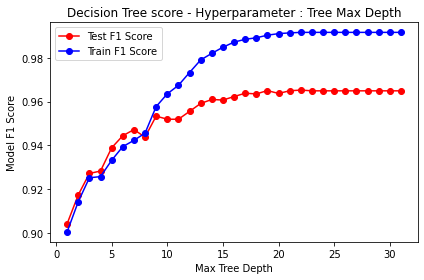


 best decision tree params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 31, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 100, 'splitter': 'best'}

 feature importance:                                     0
SSLfinal_State_1             0.504419
URL_of_Anchor_-1             0.138295
web_traffic_0                0.040618
Prefix_Suffix                0.030500
Links_in_tags_-1             0.026135
having_Sub_Domain_1          0.018203
URL_of_Anchor_0              0.018014
age_of_domain                0.016113
Request_URL                  0.014833
Google_Index                 0.012683
DNSRecord                    0.012638
having_IP_Address            0.012576
Page_Rank                    0.011547
SFH_-1                       0.011248
Domain_registeration_length  0.009747
Links_in_tags_0              0.008793
Links_pointing_to_page_0

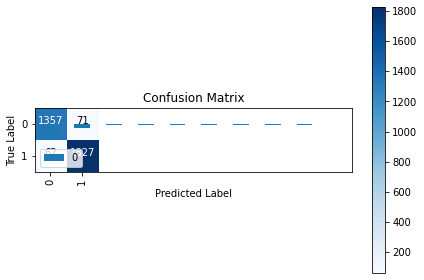

(21, 0.96522655426765)

In [121]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV



# notes
# f1_score: a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
# F1 = 2 * (precision * recall) / (precision + recall)

# train decision tree 
def trainDT(x_train, y_train, x_test, y_test, feature_names, maxdepth = 32):

    f1_train = [] # to store the score of training dataset
    f1_test = [] # to store the score of test dataset
    max_depth = list(range(1, maxdepth)) # for plotting
    
    maxScore = 0
    for i in max_depth:         
        clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=1, criterion='entropy')
        clf.fit(x_train, y_train)

        y_pred_train = clf.predict(x_train)
        f1_train.append(f1_score(y_train, y_pred_train,pos_label='1'))

        y_pred_test = clf.predict(x_test)
        newScore = f1_score(y_test, y_pred_test,pos_label='1')
        if newScore>maxScore: bestDT = clf
        f1_test.append(newScore)

    plotScoreVSDepth(max_depth, f1_test, f1_train, "Decision Tree score - Hyperparameter : Tree Max Depth")

    
    print(f"\n best decision tree params: {bestDT.get_params()}") # to get the decision tree parameters
    
    featuresDF = pd.DataFrame(bestDT.feature_importances_, index=feature_names).sort_values(0,ascending=False)
    
    print(f"\n feature importance: {featuresDF}") # tells you which feature has the highest weight. 

    featuresDF.head(10).plot(kind='bar')
    
    
    print(f"\n probabilities: {clf.predict_proba(x_test)}")
    
    bestScore = max(f1_test) # should be equal to maxScore
    bestIndex = f1_test.index(bestScore)
    print(f"best tree is {bestIndex} level deep with a score of { bestScore }.")

    y_pred = bestDT.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred,pos_label='1')
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,pos_label='1')
    recall = recall_score(y_test,y_pred,pos_label='1')
    
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(auc)+"     AUC:          "+"{:.2f}".format(auc))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"  Accuracy:     "+"{:.2f}".format(accuracy))
    print("Precision: "+"{:.2f}".format(precision)+"  Precision: "+"{:.2f}".format(precision))
    print("Precision: "+"{:.2f}".format(recall)+"     Recall:    "+"{:.2f}".format(recall))
    
    
    cm = confusion_matrix(y_test, y_pred)    
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')

#     plotDecisionTree(bestDT, feature_names)
    
    return bestIndex, bestScore
        


def TreeGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    #parameters to search:
    #20 values of min_samples leaf from 0.5% sample to 5% of the training data
    #20 values of max_depth from 1, 20
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int'), 'max_depth':np.arange(1,20)}

    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=10)
    tree.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(tree.best_params_)
    return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf']    

feature_names=train.columns.values[1:]

x_train=train.values[:,1:]
y_train = train.values[:,0]


x_test = test.values[:,1:]
y_test = test.values[:,0]

# training using decision tree with various depths. 
trainDT(x_train, y_train, x_test, y_trest,feature_names)


# yet to be figured out
# start_leaf_n = round(0.005*len(x_train))
# end_leaf_n = round(0.05*len(x_train)) #leaf nodes of size [0.5%, 5% will be tested]

# print(start_leaf_n, end_leaf_n)

# print("TreeGridSearchCV ")
# max_depth, min_samples_leaf = TreeGridSearchCV(start_leaf_n, end_leaf_n, x_train, y_train)
# print("estimator")
# estimator_data = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')
# train_samp_data, DT_train_score_data, DT_fit_time_data, DT_pred_time_data = plot_learning_curve(estimator_data, x_train, y_train,title="Decision Tree")
# final_classifier_evaluation(estimator_data, x_train, x_test, y_train, y_test)

